In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab.utils.logging import ListLogger
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from tqdm import tqdm


from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import Tuple, Optional
import torch
from functorch import vmap


from functools import partial


import torchsde
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

from math import sqrt


from torchdiffeq import odeint
from torch.func import jacrev

from src.utils.data_utils import remove_mean
from src.models.components.egnn import EGNN_dynamics

from bgflow import Energy
from bgflow.utils import distance_vectors, distances_from_vectors

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
from matplotlib.patches import Rectangle

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


In [6]:
# color blind friendly colors
# fab_color = "#0072B2"
# our_color = "#009E73"
# test_color = "#D55E00"
# pis_color = "#CC79A7"
# dds_color = "#E69F00"


fab_color =  "#4daf4a"
our_color = "#377eb8" 
test_color = "#ff7f00" 
pis_color = "#a65628" #"#f781bf"
dds_color = "#e41a1c"

## Plot

In [30]:
data = "lj55"

if data == "lj13":
    dimensionality = 39
    from src.energies.lennardjones_energy import LennardJonesEnergy
    target = LennardJonesEnergy(
        dimensionality=dimensionality,
        n_particles=13,
        device=device,
        data_path = "../../data/test_split_LJ13-1000.npy",
        data_path_train =  "../../data/train_split_LJ13-1000.npy",
        data_path_val = "../../data/test_split_LJ13-1000.npy",
    )

if data == "dw4":
    dimensionality = 8
    from src.energies.multi_double_well_energy import MultiDoubleWellEnergy
    target = MultiDoubleWellEnergy(dimensionality,
                                   n_particles=4,
                                   data_path="../../data/test_split_DW4.npy",
                                   data_path_train="../../data/train_split_DW4.npy", 
                                   data_path_val="../../data/val_split_DW4.npy", 
                                   device=device)
    
if data == "lj55":
    dimensionality = 165
    from src.energies.lennardjones_energy import LennardJonesEnergy
    target = LennardJonesEnergy(
        dimensionality=dimensionality,
        n_particles=55,
        device=device,
        data_path = "../../data/test_split_LJ55-1000-part1.npy",
        data_path_train= "../../data/train_split_LJ55-1000-part1.npy",
        data_path_val = "../../data/val_split_LJ55-1000-part1.npy",
    )

In [31]:
import os
# read all files in folder
 
def read_all_files(folder):
    samples = []
    files = os.listdir(folder)
    files = [f for f in files if f.endswith(".pt") or f.endswith(".npz") and not f.startswith(".")]
    files = [os.path.join(folder, f) for f in files]
    for f in files:
        if f.endswith(".pt"):
            samples.append(torch.load(f))
        if f.endswith(".npz"):
            samples.append(torch.tensor(np.load(f, allow_pickle=True)["samples"]))
    return torch.cat(samples, dim=0)

In [32]:
# sample randomly from torch array 
def sample_from_tensor(tensor, n_samples):
    idx = torch.randperm(tensor.shape[0])[:n_samples]
    return tensor[idx]

In [42]:
fab_path = "/network/scratch/a/alexander.tong/se3_diffusion/dem/fab_samples/" + data +'/'
fab_samples = read_all_files(fab_path).to(device).reshape(-1, dimensionality)
fab_samples = sample_from_tensor(fab_samples, 100000)

# our_path = "/network/scratch/a/alexander.tong/se3_diffusion/dem/idem_samples/" + data + '/'
our_path = '/network/scratch/a/alexander.tong/se3_diffusion/dem/jarrid/'
our_samples = read_all_files(our_path).to(device).reshape(-1, dimensionality)
our_samples = sample_from_tensor(our_samples, 100000)

# pis_path = "/network/scratch/a/alexander.tong/se3_diffusion/dem/pis_samples/" + data + '/'
pis_path = "/network/scratch/a/alexander.tong/se3_diffusion/dem/idem_samples/" + data + '/old/'
pis_samples = read_all_files(pis_path).to(device).reshape(-1, dimensionality)
pis_samples = sample_from_tensor(pis_samples, 100000)

dds_path = "/network/scratch/a/alexander.tong/se3_diffusion/dem/dds_samples/" + data + '/'
dds_samples =  read_all_files(dds_path).to(device).reshape(-1, dimensionality)
dds_samples = sample_from_tensor(dds_samples, 100000)

In [43]:
fab_energy = target(fab_samples)
our_energy = target(our_samples)
pis_energy = target(pis_samples)
dds_energy = target(dds_samples)


test_samples = target.sample_test_set(fab_samples.shape[0])
test_energy = target(test_samples)

In [44]:
fab_energy = fab_energy[fab_energy>0]
our_energy = our_energy[our_energy>0]
pis_energy = pis_energy[pis_energy>0]
dds_energy = dds_energy[dds_energy>0]

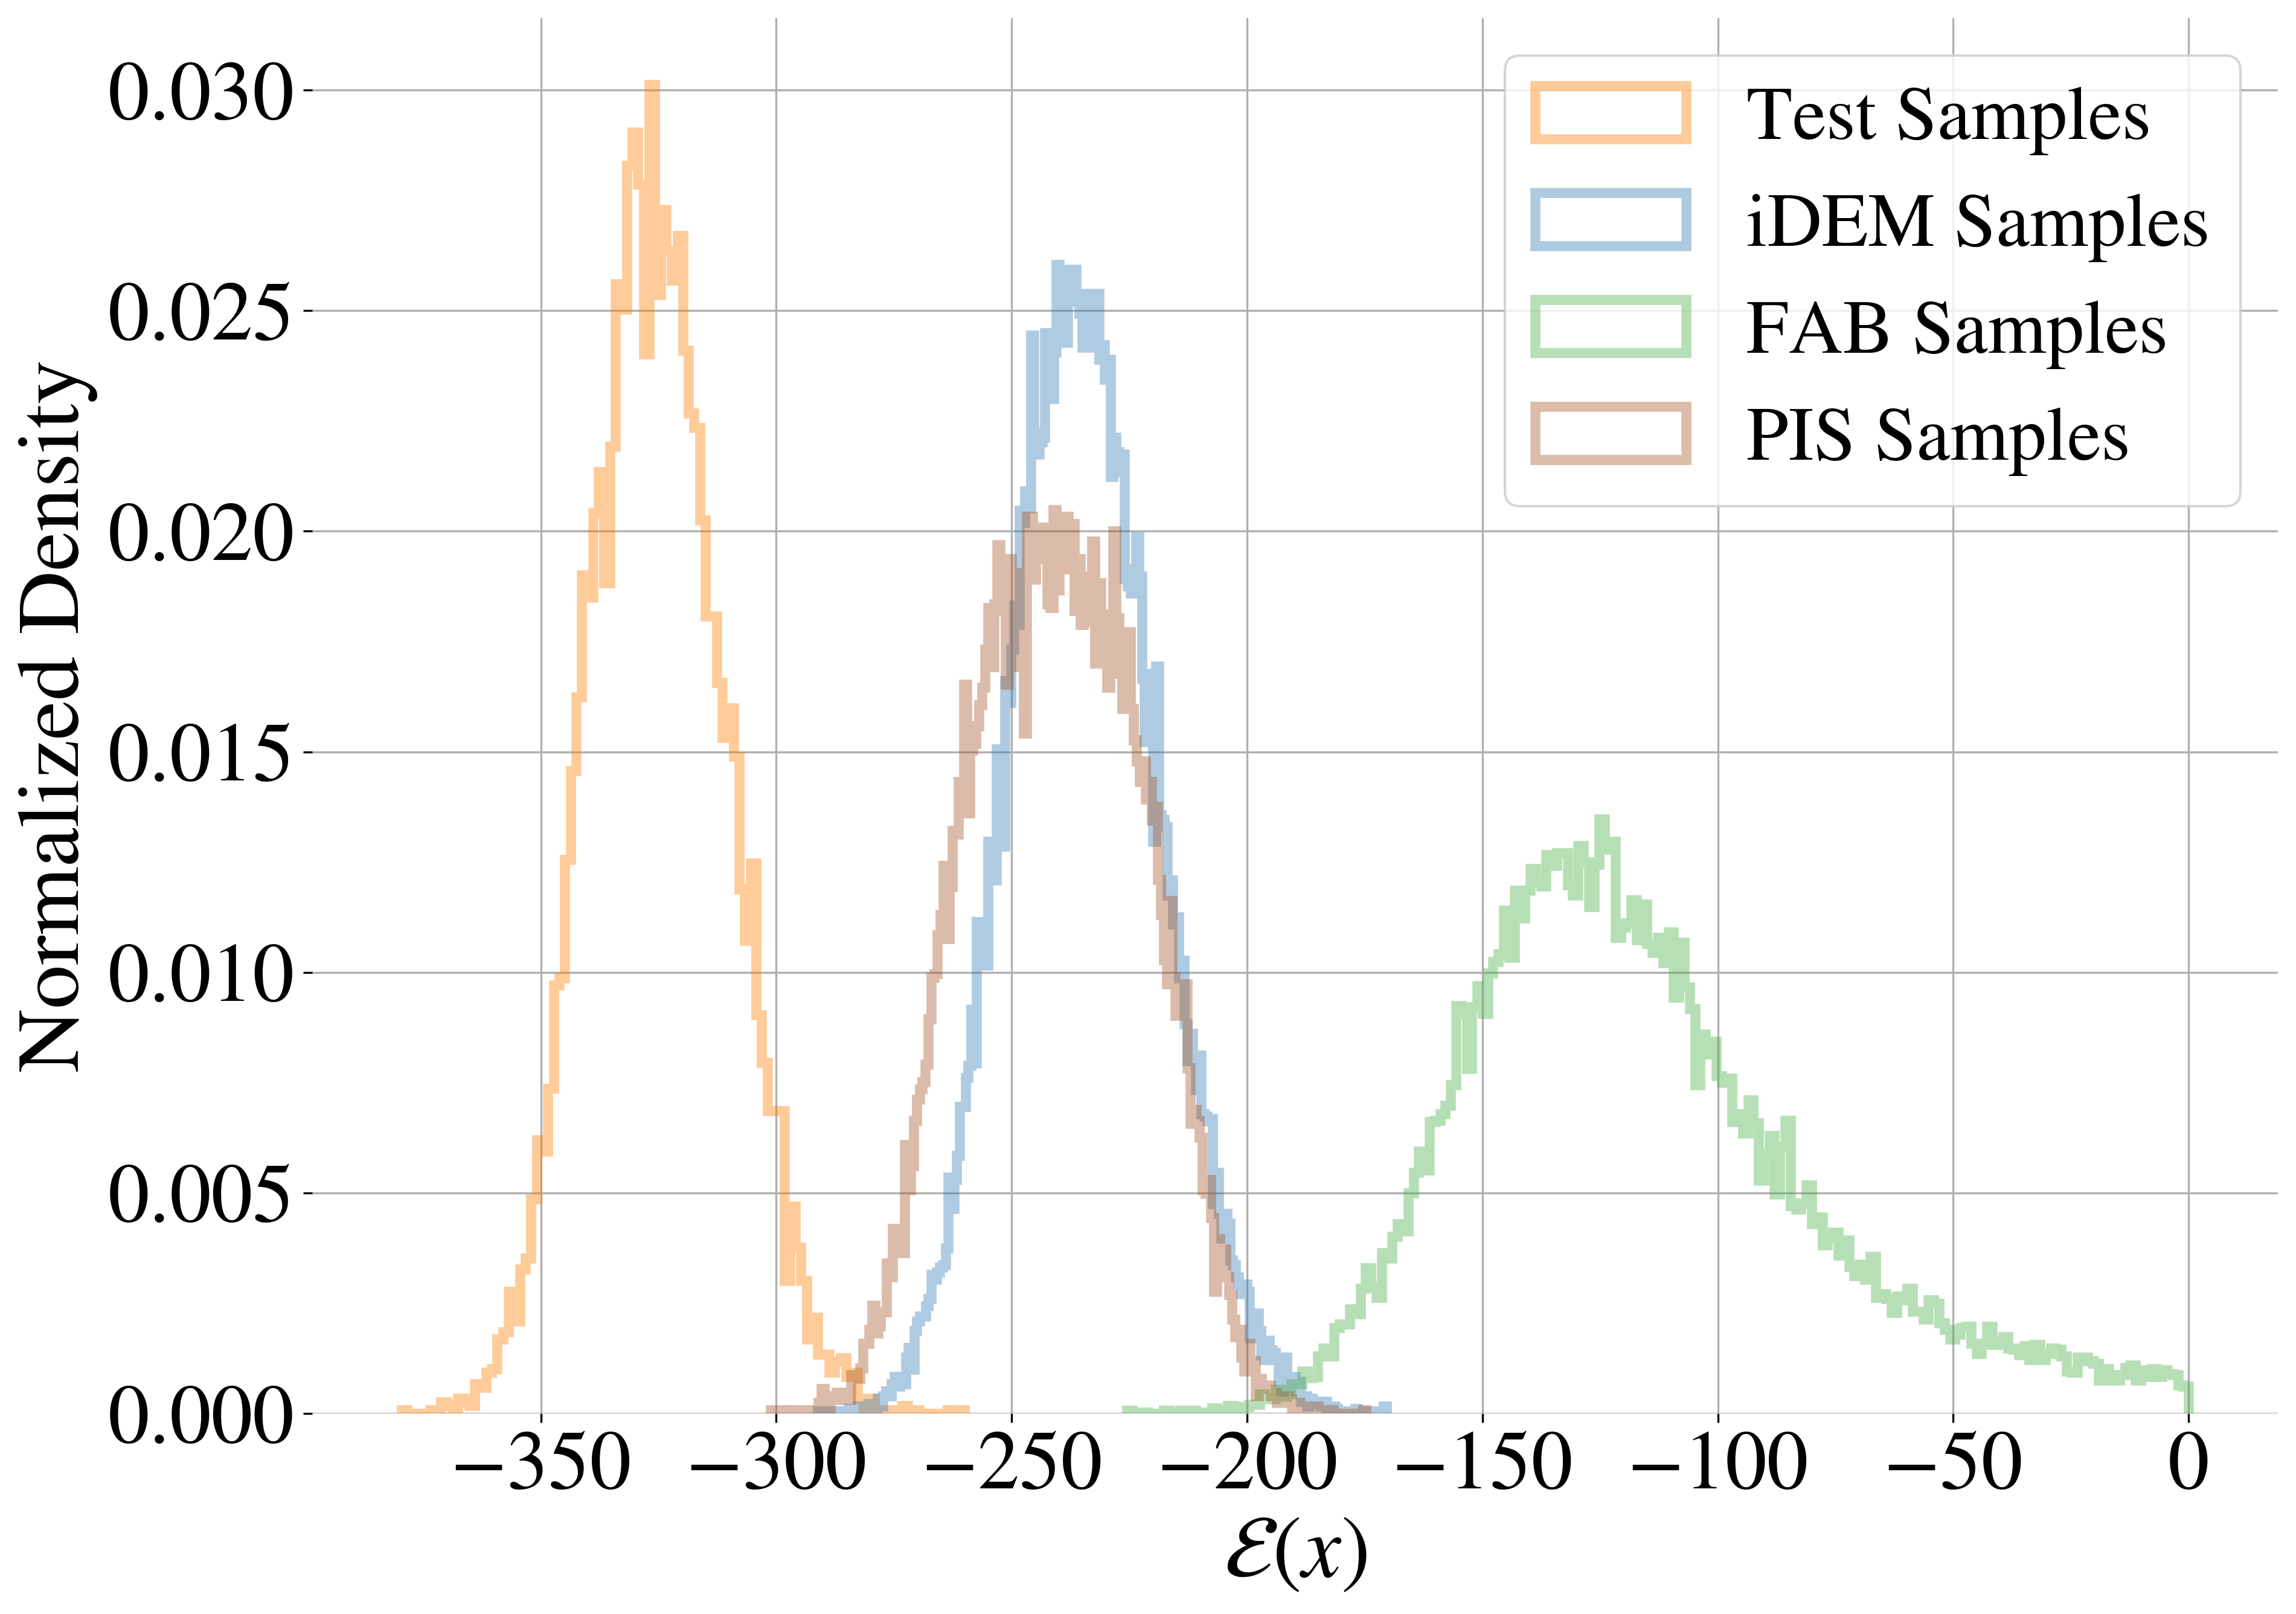

In [45]:
fig, ax = plt.subplots(figsize = (14,10),dpi=300)
fig.patch.set_facecolor('white')

_, bins, _= plt.hist(-test_energy.detach().cpu(), bins=100, density=True, alpha=0.4,
    color=test_color, histtype='step', linewidth=4, label="Test Samples");

plt.hist(-our_energy.detach().cpu(), bins=200, density=True, alpha=0.4,
    color=our_color, histtype='step', linewidth=4, label="iDEM Samples");

plt.hist(-fab_energy.detach().cpu(), bins=200, density=True, alpha=0.4,
    color=fab_color, histtype='step', linewidth=4, label="FAB Samples")

plt.hist(-pis_energy.detach().cpu(), bins=200, density=True, alpha=0.4,
    color=pis_color, histtype='step', linewidth=4, label="PIS Samples");

# plt.hist(-dds_energy.detach().cpu(), bins=bins, density=True, alpha=0.4,
#     color=dds_color, histtype='step', linewidth=4, label="DDS Samples");
    

plt.legend()


# lim_min = - (test_energy.max().item() + 80)
# lim_max = - (test_energy.min().item() - 80)
# plt.xlim(lim_min, lim_max)

plt.xticks(fontsize=33)
plt.yticks(fontsize=33)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True)
ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())

plt.xlabel(r"$\mathcal{E}(x)$",fontsize=35)
plt.ylabel("Normalized Density",fontsize=35)
plt.legend(fontsize=30)
plt.savefig('../../figures/' + data + '_energy.png',bbox_inches='tight')
plt.show()

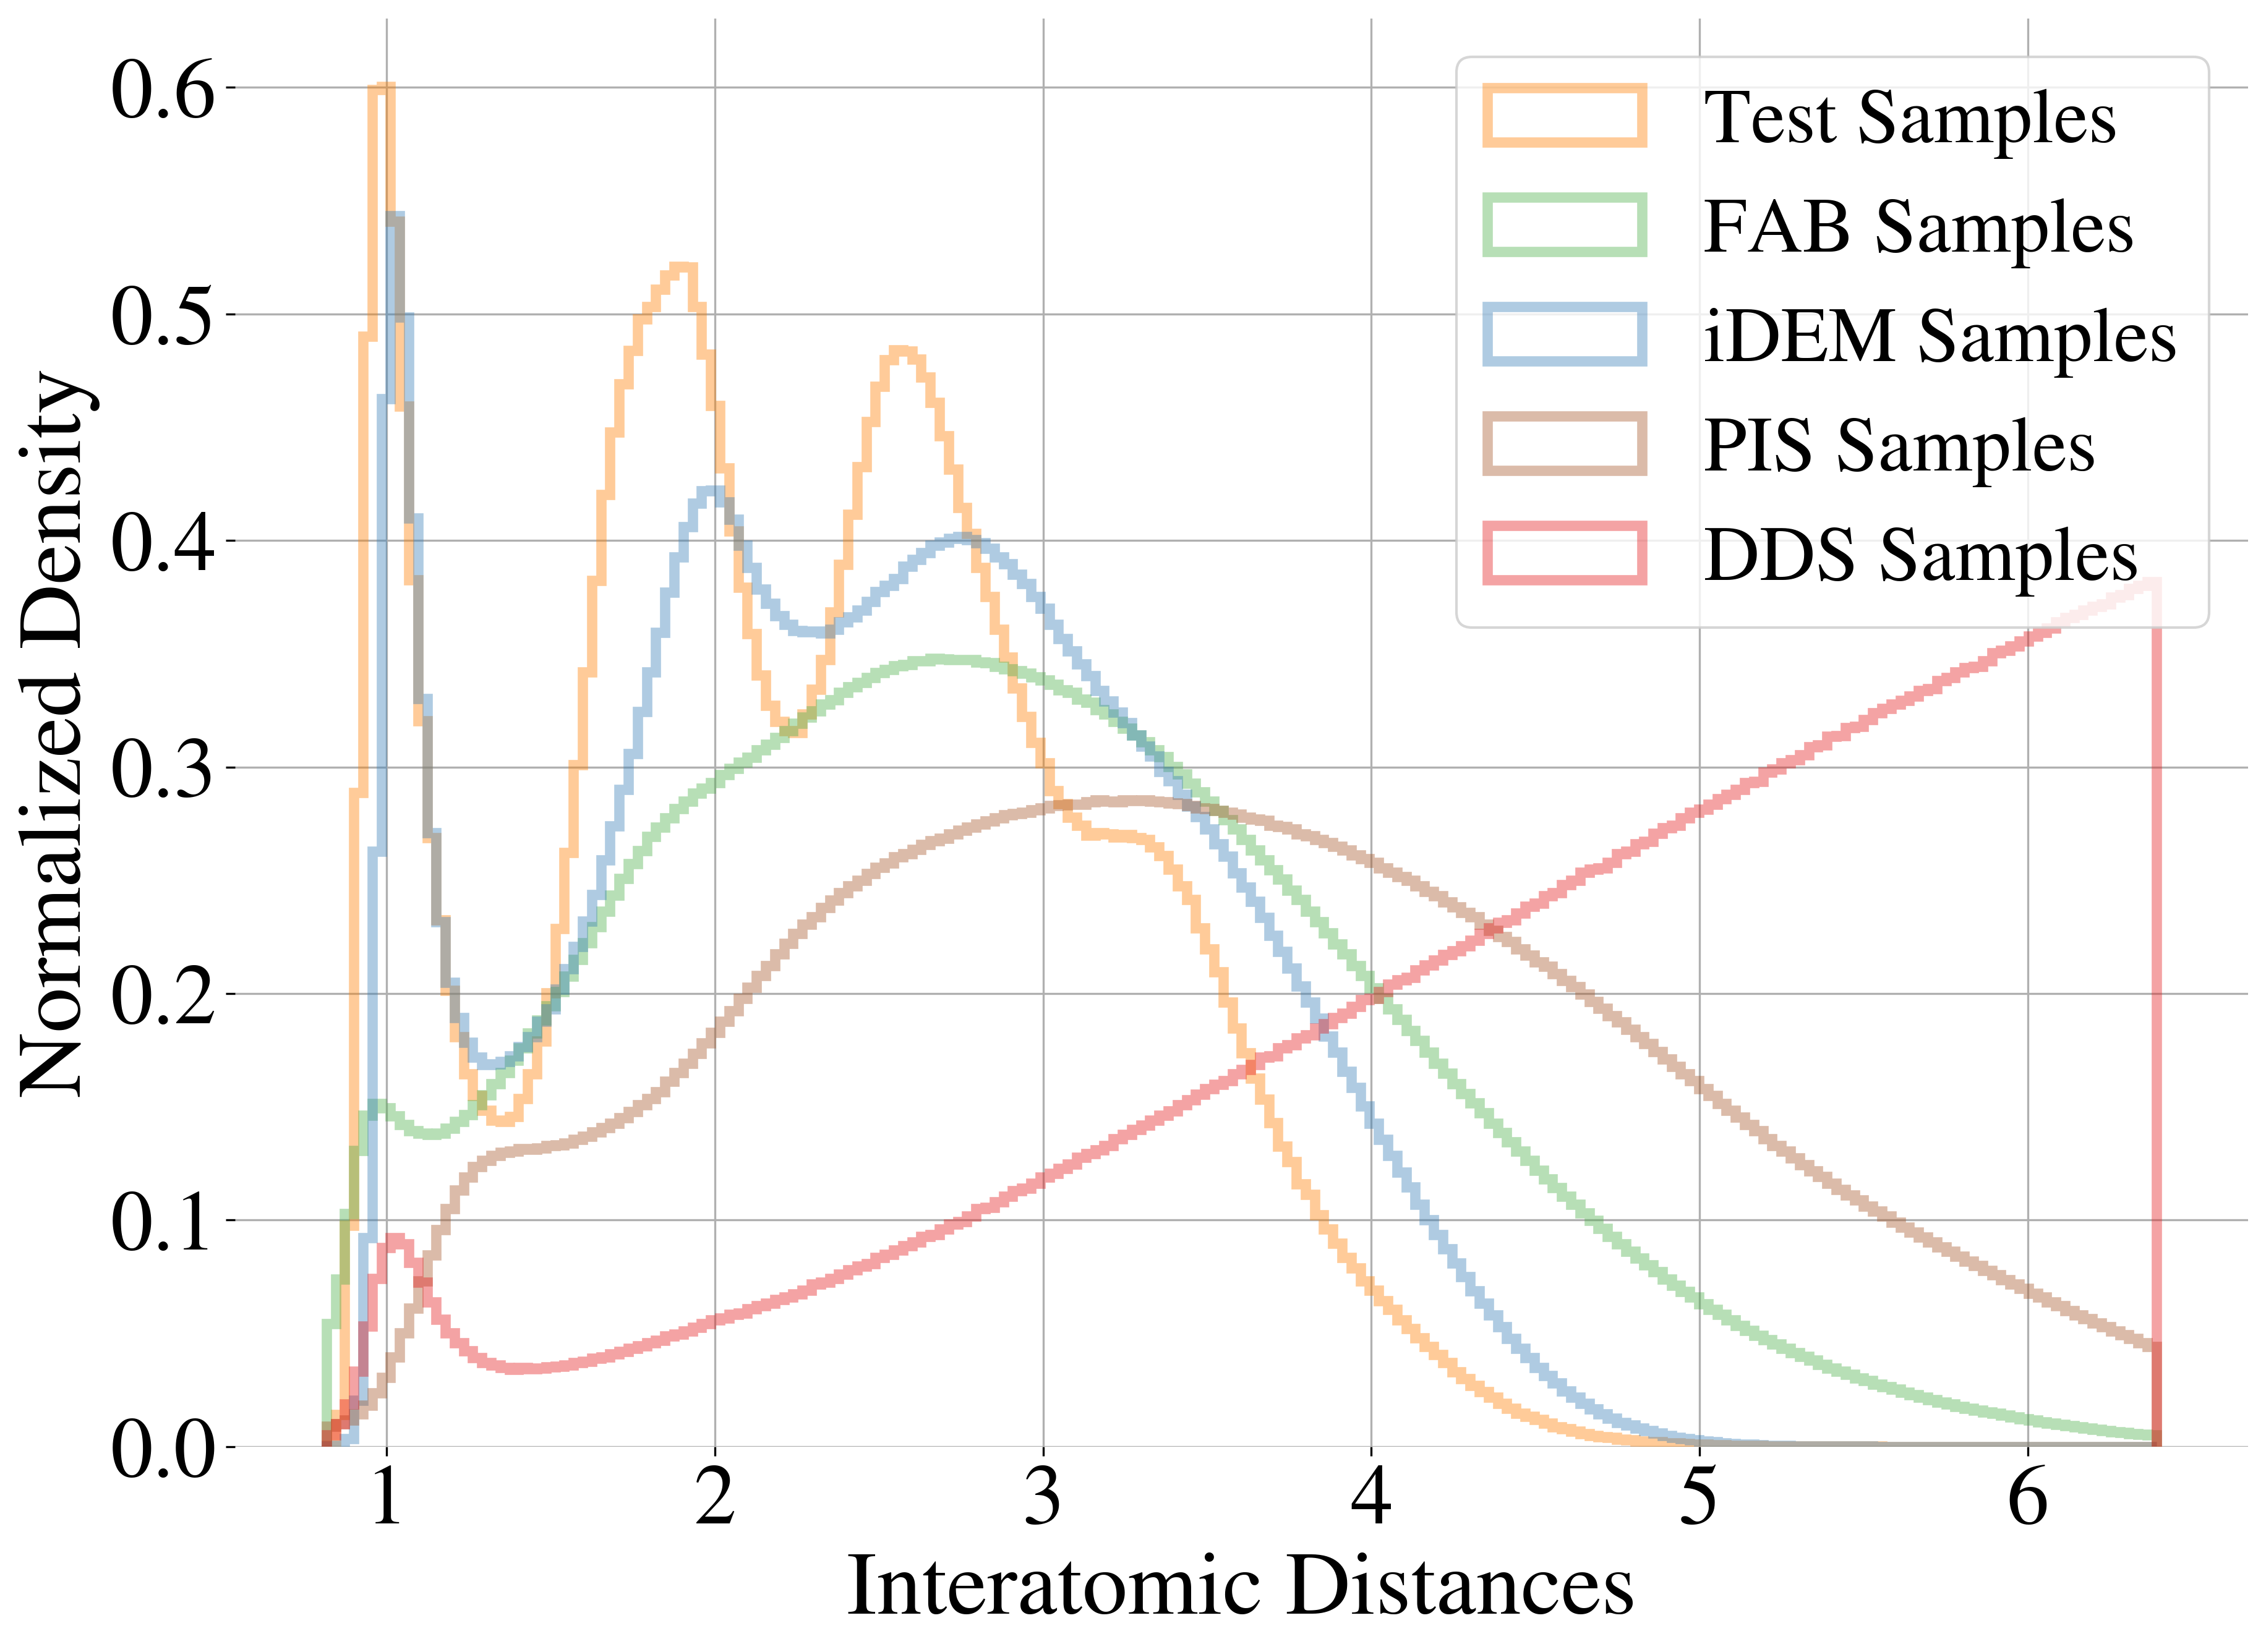

In [37]:
fig, ax = plt.subplots(figsize = (14,10),dpi=300)
fig.patch.set_facecolor('white')

_, bins, _ = plt.hist(
    target.interatomic_dist(test_samples).detach().view(-1).cpu().numpy(),
    bins=200,
    density=True,
    histtype="step",
    linewidth=4,
    alpha=0.4,
    label="Test Samples",
    color=test_color
)

plt.hist(
    target.interatomic_dist(fab_samples).detach().view(-1).cpu().numpy(),
    bins=bins,
    density=True,
    histtype="step",
    linewidth=4,
    alpha=0.4,
    label="FAB Samples",
    color=fab_color
)

plt.hist(
    target.interatomic_dist(our_samples).detach().view(-1).cpu().numpy(),
    bins=bins,
    density=True,
    histtype="step",
    linewidth=4,
    alpha=0.4,
    label="iDEM Samples",
    color=our_color
)

plt.hist(
    target.interatomic_dist(pis_samples).detach().view(-1).cpu().numpy(),
    bins=bins,
    density=True,
    histtype="step",
    linewidth=4,
    alpha=0.4,
    label="PIS Samples",
    color=pis_color
)

plt.hist(
    target.interatomic_dist(dds_samples).detach().view(-1).cpu().numpy(),
    bins=bins,
    density=True,
    histtype="step",
    linewidth=4,
    alpha=0.4,
    label="DDS Samples",
    color=dds_color
)

plt.xticks(fontsize=33)
plt.yticks(fontsize=33)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True)
ax.xaxis.set_minor_locator(NullLocator())
ax.yaxis.set_minor_locator(NullLocator())

plt.xlabel("Interatomic Distances",fontsize=35)
plt.ylabel("Normalized Density",fontsize=35)
plt.legend(fontsize=30)
plt.savefig('../../figures/' + data + '_interatomic_dists.png',bbox_inches='tight')
# plt.show()
